In [22]:
#!pip install python-docx

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 239 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.0 MB 69.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [21]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from docx import Document
import matplotlib.pyplot as plt
from shapely import wkt
import geopandas as gpd


PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
import dataset

In [17]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-CNN.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')
df['Zip_cd'] = df['Zip_cd'].astype(str)
df['NumberFloors_nb'] = pd.to_numeric(df['NumberFloors_nb'], errors='coerce')
df

,Unnamed: 0,PropertyKey_ID,Deal_id,Property_id,Status_tx,Status_dt,TransType_tx,country,Main Type,SubType,...,BldLenProxy,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,_merge
0,503,258966,499814,464167,closed,15/03/2008,Entity Level,Netherlands,Apartment,Garden,...,8.480678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,511,259004,488808,451626,closed,22/01/2008,Sale,Netherlands,Dev Site,Dev Site,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,512,259005,500721,465261,closed,15/03/2008,Sale,Netherlands,Dev Site,Dev Site,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,513,259006,502381,467404,closed,09/02/2007,Sale,Netherlands,Office,Office - Sub,...,33.402783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,514,259007,2309350,1997038,closed,28/03/2019,Sale,Netherlands,Office,Office - Sub,...,46.501498,0.225379,0.143153,0.081831,0.104223,0.180017,0.095836,0.169561,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6136,83889,2385505,3729803,3717637,closed,29/03/2023,Sale,Spain,Industrial,Warehouse,...,56.329767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6137,83905,2386951,3732279,3720303,closed,30/03/2023,Sale,Spain,Office,Office - Sub,...,50.229888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6138,83908,2387013,3732377,3720401,closed,31/03/2023,Sale,Spain,Seniors Housing & Care,Seniors Housing,...,34.945676,0.224388,0.125826,0.112308,0.131752,0.154641,0.132850,0.118236,0.0,both
6139,84167,2403285,3758153,3747999,closed,20/04/2023,Sale,Spain,Hotel,Limited Service,...,24.292422,0.292903,0.168690,0.100329,0.103362,0.138473,0.096957,0.099285,0.0,both


In [18]:
# Separate numeric and non-numeric (categorical) columns
numeric_cols = df.select_dtypes(include=[np.number])  # Selects all numeric columns
categorical_cols = df.select_dtypes(exclude=[np.number])  # Selects all non-numeric columns

# Summary for numeric columns: default stats including mean, std, etc.
numeric_summary = numeric_cols.describe().round(3).transpose()
numeric_summary.reset_index(inplace=True)
numeric_summary.rename(columns={'index': 'Statistic'}, inplace=True)
numeric_summary.insert(0, 'Data Source', 'Numeric Data')  # Change as necessary
numeric_summary.insert(2, 'Variable Description', 'Numerical Summary')

# Summary for categorical columns: count, unique, top, freq
categorical_summary = categorical_cols.describe(include='all').transpose()
categorical_summary.reset_index(inplace=True)
categorical_summary.rename(columns={'index': 'Statistic'}, inplace=True)
categorical_summary.insert(0, 'Data Source', 'Categorical Data')  # Change as necessary
categorical_summary.insert(2, 'Variable Description', 'Categorical Summary')


In [19]:
from docx import Document

def df_to_word(numeric_df, categorical_df, filename):
    doc = Document()
    
    # Adding Numeric Summary Table
    doc.add_heading('Numeric Summary Statistics', level=1)
    num_table = doc.add_table(rows=(numeric_df.shape[0] + 1), cols=numeric_df.shape[1])
    for i, col_name in enumerate(numeric_df.columns):
        num_table.cell(0, i).text = str(col_name)
    for row_index, row in numeric_df.iterrows():
        for col_index in range(numeric_df.shape[1]):
            num_table.cell(row_index + 1, col_index).text = str(row[col_index])
    num_table.style = 'Table Grid'
    
    # Adding Categorical Summary Table
    doc.add_heading('Categorical Summary Statistics', level=1)
    cat_table = doc.add_table(rows=(categorical_df.shape[0] + 1), cols=categorical_df.shape[1])
    for i, col_name in enumerate(categorical_df.columns):
        cat_table.cell(0, i).text = str(col_name)
    for row_index, row in categorical_df.iterrows():
        for col_index in range(categorical_df.shape[1]):
            cat_table.cell(row_index + 1, col_index).text = str(row[col_index])
    cat_table.style = 'Table Grid'

    # Save the document
    doc.save(filename)

# Example usage
df_to_word(numeric_summary, categorical_summary, '/workspace/workspace/ufo-prediction/main notebooks/summary_statistics.docx')



# Building Age distribution

In [20]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df_scaled = pd.read_csv(path_data_RCA, encoding='latin1')

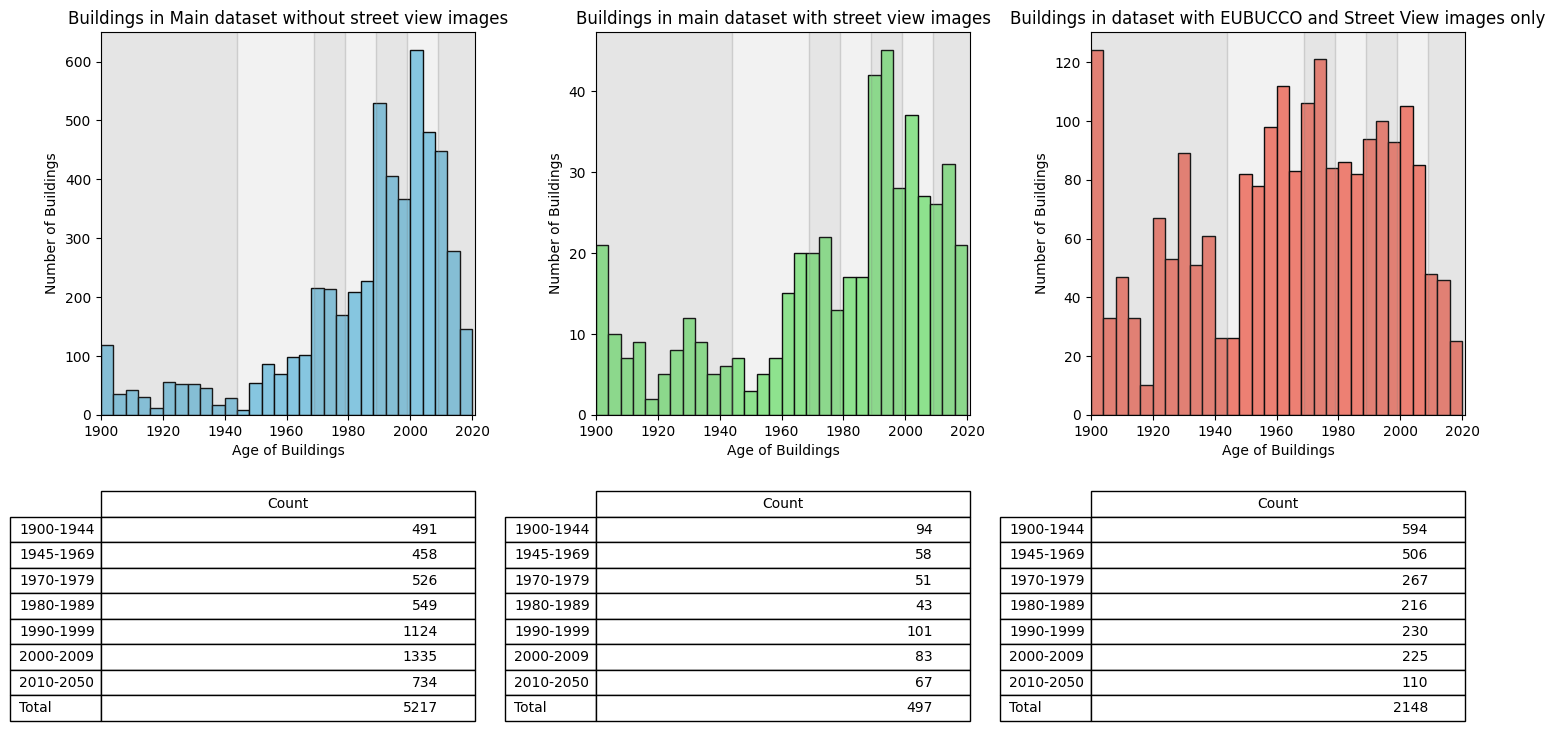

In [38]:
# Filtering to keep only buildings from 1900 onwards
df = df[df['age_right'] >= 1900]
df_scaled = df_scaled[df_scaled['age'] >= 1900]


# Define the age brackets
age_bins = [1900, 1944, 1969, 1979, 1989, 1999, 2009, 2050]
age_bins2 = [1900, 1944, 1969, 1979, 1989, 1999, 2009, 2021]
age_labels = ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']

# Categorizing the 'age_right' and 'age' columns into age brackets
df['age_right_bracket'] = pd.cut(df['age_right'], bins=age_bins, labels=age_labels, right=False)
df_scaled['age_bracket'] = pd.cut(df_scaled['age'], bins=age_bins, labels=age_labels, right=False)

# Filtering data based on '_merge' values
df_only_left = df[df['_merge'] == 'left_only']
df_both = df[df['_merge'] == 'both']

# Histogram plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 1, 1]})
colors = ['skyblue', 'lightgreen', 'salmon']
data_sets = [df_only_left['age_right'], df_both['age_right'], df_scaled['age']]

for ax, data, color in zip(axs, data_sets, colors):
    ax.hist(data, color=color, edgecolor='black', bins=30)  # Specifying 30 bins for better granularity
    ax.set_xlim([1900, 2021])  # Set x-axis limits
    for i in range(len(age_bins)-1):
        ax.axvspan(age_bins[i], age_bins[i+1], color='gray', alpha=0.2 if i % 2 == 0 else 0.1)

# Adding titles and labels
titles = [
    'Buildings in Main dataset without street view images',
    'Buildings in main dataset with street view images',
    'Buildings in dataset with EUBUCCO and Street View images only'
]
for ax, title in zip(axs, titles):
    ax.set_title(title)
    ax.set_xlabel('Age of Buildings')
    ax.set_ylabel('Number of Buildings')

# Creating the tables below the histograms
for ax, data, column in zip(axs, [df_only_left, df_both, df_scaled], ['age_right_bracket', 'age_right_bracket', 'age_bracket']):
    count_data = data[column].value_counts().reindex(age_labels, fill_value=0)
    total_count = np.array([count_data.sum()])  # Calculate total count
    count_data_with_total = np.concatenate((count_data.values, total_count))  # Append total count
    row_labels_with_total = np.append(age_labels, 'Total')  # Append 'Total' label
    table = ax.table(cellText=count_data_with_total[:, np.newaxis], rowLabels=row_labels_with_total, colLabels=['Count'], loc='bottom', bbox=[0, -0.8, 1, 0.6])

plt.tight_layout()
plt.subplots_adjust(bottom=0.4)  # Adjust the bottom margin to make more room for the tables
plt.show()


In [ ]:
# Convert geometry data from WKT format if necessary
df['geometry'] = df['geometry'].apply(wkt.loads)
df_scaled['geometry'] = df_scaled['geometry'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf_scaled = gpd.GeoDataFrame(df_scaled, geometry='geometry')

# Load NUTS2 shapefiles (replace 'path_to_shapefile' with the path to the shapefile you download)
nuts2 = gpd.read_file('path_to_shapefile')

# Filter the shapefile for France, Netherlands, and Spain NUTS2 regions
nuts2 = nuts2[nuts2['CNTR_CODE'].isin(['FR', 'NL', 'ES'])]

# Merge the data with NUTS2 regions based on locations
buildings_nuts2 = gpd.sjoin(gdf, nuts2, how="inner", op='intersects')

# Calculate average age and count of buildings per NUTS2 region
region_stats = buildings_nuts2.groupby('NUTS_ID').agg({'age_right': 'mean', 'geometry': 'count'}).rename(columns={'geometry': 'count'})

# Merge stats back into the NUTS2 GeoDataFrame
nuts2 = nuts2.merge(region_stats, on='NUTS_ID', how='left')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

nuts2.plot(ax=ax, column='age_right', cmap='RdYlGn', legend=True,
           legend_kwds={'label': "Average Age of Buildings"},
           alpha=nuts2['count'].transform(lambda x: x / x.max()))  # Normalizing count for opacity

# Add a basemap
ctx.add_basemap(ax, crs=nuts2.crs.to_string(), source=ctx.providers.CartoDB.Positron)

ax.set_title('Buildings Age and Density by NUTS2 Region')
ax.set_axis_off()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Filter out the 'No Match' category from the 'match_type' column
filtered_matches = matches[matches['match_type'] != 'no match']

# Create the bar plot and get the axis object
ax = filtered_matches['match_type'].value_counts().plot(kind='bar')

plt.xlabel('Match Type')
plt.ylabel('Count')
plt.title('Distribution of Match Types')

# Adding the text on top of each bar
for bar in ax.patches:
    # The text to display (bar height)
    yval = bar.get_height()
    # Placing the text above the bar
    ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'matches' is your DataFrame and it has a numerical column named 'distances'
matches['distances'].plot(kind='hist', bins=20)  # You can adjust the number of bins

plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.show()

In [ ]:
    # Idea: periods with more buildings will not be brighter than periods with little buildings
import matplotlib
from matplotlib.gridspec import GridSpec

bins = list(range(min_age, max_age + 1, 5))
ticks = [1920, 1940, 1960, 1980, 2000]
X, Y = np.meshgrid(bins, bins)
age_ufo = matches['age_right']
age_rca = matches['YearBlt']
H = np.histogram2d(age_ufo, age_rca, bins=bins)[0]
# H_norm: each row describes relative share of all prediction age bands for buildings of a certain test band
H_norm = (H.T / H.sum(axis=1)).T
#H_norm[np.isinf(H_norm)] = 0
#H_norm[np.isnan(H_norm)] = 0

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', 'cadetblue'])
colors = ['thistle', 'lightsteelblue', 'plum']

ax_scatter.plot([0, 1], [0, 1], transform=ax_scatter.transAxes, color='cadetblue')
ax_scatter.pcolormesh(X, Y, H_norm, cmap=cmap, rasterized=True)
ax_scatter.set_yticks(ticks, labels=ticks)
ax_scatter.set_xticks(ticks, labels=ticks)


ax_hist_x.hist(matches['YearBlt'], bins=bins, color=colors[0], alpha=0.4)
ax_hist_y.hist(matches['age_right'], bins=bins, orientation='horizontal', color=colors[0], alpha=0.4)


ax_hist_x.set_axis_off()
ax_hist_y.set_axis_off()
fig.subplots_adjust(hspace=0.05, wspace=0.02)

ax_scatter.spines['top'].set_linewidth(0.5)
ax_scatter.spines['right'].set_linewidth(0.5)
ax_scatter.spines['left'].set_linewidth(0.5)
ax_scatter.spines['bottom'].set_linewidth(0.5)

ax_scatter.set_xlabel('RCA construction year')
ax_scatter.set_ylabel('UFO construction year')
plt.show()

In [ ]:
class SubplotManager:
    def __init__(self, **kwargs):
        ax = kwargs.get('ax')
        self.mainplot = not bool(ax)
        self.ax = ax or plt.subplots(**{'figsize': (12, 12), **kwargs})[1]

        SMALL_SIZE = 10
        MEDIUM_SIZE = 12
        BIGGER_SIZE = 14
        # SMALL_SIZE = 18
        # MEDIUM_SIZE = 20
        # BIGGER_SIZE = 22

        plt.rc('font', size=BIGGER_SIZE)
        plt.rc('axes', titlesize=BIGGER_SIZE)
        plt.rc('axes', labelsize=MEDIUM_SIZE)
        plt.rc('xtick', labelsize=MEDIUM_SIZE)
        plt.rc('ytick', labelsize=MEDIUM_SIZE)
        plt.rc('legend', fontsize=SMALL_SIZE)
        plt.rc('figure', titlesize=BIGGER_SIZE)


    def __enter__(self):
        return self.ax


    def __exit__(self, exc_type, exc_value, exc_traceback):
        if self.mainplot:
            plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_histogram(y_test, y_predict, bins=None, bin_labels=[], **kwargs):
    with SubplotManager(**kwargs) as ax:
        if bin_labels:
            ax.set_xticklabels([None] + bin_labels)

        sns.histplot(
            y_predict,
            ax=ax,
            kde=False,
            line_kws=dict(edgecolor="k", linewidth=1),
            palette='Set2',
            bins=bins,
            label='UFO construction year'
        )
        sns.histplot(
            y_test,
            ax=ax,
            kde=False,
            line_kws=dict(edgecolor="k", linewidth=1),
            palette='husl',
            bins=bins,
            label='RCA construction year'
        )
        ax.legend()
        ax.set_title('age distributions')

In [ ]:
#YearBlt is y_test
# Filter out the rows where 'match_type' is 'no match'
matches_new = matches[matches['match_type'] != 'no match']
matches_new2 = matches_new[matches_new['YearBlt'].notna()]
plot_histogram(matches_new2['YearBlt'], matches_new2['age_right'], bins=list(range(min_age, max_age + 1))[0::1])

ESP <br>
Total buildings in ESP in RCA: 3934 <br>
Total buildings in ESP in RCA with age:  <br>
Total matches: 2906 <br>
Matches after filtering those that have distance > footprint length: 1747 <br>
Matches after filtering for age differences > 10 years: 1482 <br>
Of which YearBlt is defined: 549 <br>

FRA <br>
Total buildings in FRA in RCA: 10476 <br>
Total buildings in FRA in RCA with age: 6393 <br>
Total matches: 3217, there is a lot of matches where the RCA year is near 2020, but the ufo one is much older. Youngest ufo building is 2017 which is also strange <br>
Matches after filtering those that have distance > footprint length: 1100 <br>
Matches after filtering for age differences > 10 years:  870 <br>
Of which YearBlt is defined: 408 <br>



NLD <br>
Total buildings in NLD in RCA: 10136 <br>
Total buildings in NLD in RCA with age: 8050 <br>
Total matches: 7318, there is a lot of matches where the RCA year is near 2020, but the ufo one is much older. Youngest ufo building is 2020 which is also strange <br>
Matches after filtering those that have distance > footprint length: 4560 <br>
Matches after filtering for age differences > 10 years: 3789 <br>
Of which YearBlt is defined: 3211 <br>

In [ ]:
from sklearn import metrics

print('MAE: {:.2f} y'.format(metrics.mean_absolute_error(matches_new2['age_right'], matches_new2['YearBlt'])))
print('RMSE: {:.2f} y'.format(np.sqrt(metrics.mean_squared_error(matches_new2['age_right'], matches_new2['YearBlt']))))
print('R2: {:.4f}'.format(metrics.r2_score(matches_new2['YearBlt'], matches_new2['age_right'])))